In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta  # Technical Analysis library
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt


In [2]:
# Download data
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'
STOCKS = ['AAPL','TSLA', 'AMZN', 'GOOGL', 'MSFT', 'META','NVDA']

def download_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df = df.dropna()
        data[ticker] = df
    return data

data = download_data(STOCKS, START_DATE, END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Add technical indicators
def add_technical_indicators(df):
    close = df['Close']
    
    # Ensure 'close' is a Series
    if isinstance(close, pd.DataFrame):
        close = close.squeeze()
    
    # Ensure 'close' is 1D
    if len(close.shape) > 1:
        close = close.flatten()
    
    # Compute indicators
    df['MA50'] = ta.trend.sma_indicator(close, window=50)
    df['MA200'] = ta.trend.sma_indicator(close, window=200)
    df['RSI'] = ta.momentum.RSIIndicator(close, window=14).rsi()
    df['MACD'] = ta.trend.MACD(close).macd()
    
    df = df.dropna()
    return df

for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])
    
print(data)    

{'AAPL': Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2010-10-18    9.580286   11.357143   11.392857   11.224643   11.373929   
2010-10-19    9.323903   11.053214   11.206071   10.715000   10.835714   
2010-10-20    9.355239   11.090357   11.223214   10.959643   11.035714   
2010-10-21    9.324810   11.054286   11.240714   10.957143   11.155714   
2010-10-22    9.263050   10.981071   11.072857   10.939286   11.038214   
...                ...         ...         ...         ...         ...   
2020-12-23  128.059875  130.960007  132.429993  130.779999  132.160004   
2020-12-24  129.047531  131.970001  133.460007  131.100006  131.320007   
2020-12-28  133.663010  136.690002  137.339996  133.509995  133.990005   
2020-12-29  131.883316  134.869995  138.789993  134.339996  138.050003   
2020-12-30  130.758759  133.7

In [4]:
TRAIN_TEST_SPLIT = 0.8
for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])

train_data = {}
test_data = {}
for ticker in STOCKS:
    df = data[ticker]
    split_idx = int(len(df) * TRAIN_TEST_SPLIT)
    train_data[ticker] = df[:split_idx]
    test_data[ticker] = df[split_idx:]

In [5]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_balance=100000, window_size=60):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.window_size = window_size
        self.current_step = 0
        self.balance = initial_balance
        self.net_worth = initial_balance
        self.shares_held = 0
        self.max_steps = len(self.df) - window_size
        self.action_space = spaces.Discrete(7)
    
        # Observation space
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(window_size, len(self.df.columns)),
            dtype=np.float32
        )

    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        frame = self.df.iloc[self.current_step:self.current_step + self.window_size]
        obs = frame.values
        return obs.astype(np.float32)

    def step(self, action):
        
        # Ensure current_price is a scalar float
        current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])
        done = False

        # Before executing action
        prev_net_worth = self.net_worth
        shares_traded = 0

        # Execute action
        if action == 1:  # Buy 10%
            amount = self.initial_balance * 0.1
        elif action == 2:  # Buy 50%
            amount = self.initial_balance * 0.5
        elif action == 3:  # Buy 100%
            amount = self.balance
        elif action == 4:  # Sell 10%
            amount = self.shares_held * current_price * 0.1
        elif action == 5:  # Sell 50%
            amount = self.shares_held * current_price * 0.5
        elif action == 6:  # Sell 100%
            amount = self.shares_held * current_price
        else:  # Hold
            amount = 0

        # Execute buy/sell
        if action in [1, 2, 3]:  # Buy actions
            shares_to_buy = int(amount // current_price)
            if shares_to_buy > 0 and self.balance >= shares_to_buy * current_price:
                self.balance -= shares_to_buy * current_price
                self.shares_held += shares_to_buy
                shares_traded = shares_to_buy
        elif action in [4, 5, 6]:  # Sell actions
            shares_to_sell = int(amount // current_price)
            if shares_to_sell > 0 and self.shares_held >= shares_to_sell:
                self.balance += shares_to_sell * current_price
                self.shares_held -= shares_to_sell
                shares_traded = shares_to_sell

        # Move to next timestep
        self.current_step += 1

        # Update net worth
        self.net_worth = self.balance + self.shares_held * current_price

        # Calculate reward
        reward = self.net_worth - prev_net_worth

        # Transaction cost (e.g., 0.1% per trade)
        transaction_cost = 0.001 * current_price * shares_traded
        reward -= transaction_cost

        # Normalize reward
        reward /= self.initial_balance


        if self.current_step >= self.max_steps:
            done = True

        obs = self._next_observation()
        return obs, reward, done, {}


    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')

In [6]:
class DeepQNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layers=2, hidden_dim=64, output_dim=3, dropout_rate=0.2):
        super(DeepQNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)    


In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_dim=64, learning_rate=1e-3, gamma=0.95, device='cuda',epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.1, 
                 batch_size=64, memory_size=100000):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.device = torch.device(device)
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Q-Network and Target Network
        self.q_network = DeepQNet(input_dim=state_size, hidden_dim=hidden_dim, output_dim=action_size).to(self.device)
        self.target_network = DeepQNet(input_dim=state_size, hidden_dim=hidden_dim, output_dim=action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Replay Memory
        self.memory = deque(maxlen=100000)

        # Exploration parameters
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def remember(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            act_values = self.q_network(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        minibatch = random.sample(self.memory, batch_size)
        states = torch.stack([s[0] for s in minibatch]).to(self.device)
        actions = torch.LongTensor([s[1] for s in minibatch]).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor([s[2] for s in minibatch]).unsqueeze(1).to(self.device)
        next_states = torch.stack([s[3] for s in minibatch]).to(self.device)
        dones = torch.FloatTensor([s[4] for s in minibatch]).unsqueeze(1).to(self.device)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min

        # Current Q values
        q_values = self.q_network(states).gather(1, actions)

        # Double DQN Target Q values
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(dim=1, keepdim=True)
            next_q_values = self.target_network(next_states).gather(1, next_actions)
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [8]:
def train_dqn_agent(env, agent, num_episodes=100, batch_size=64, target_update_freq=10):
    rewards_history = []
    losses = []

    for e in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Flatten the observation
            state_flat = state.flatten()
            # Select action
            action = agent.act(state_flat)
            # Execute action
            next_state, reward, done, _ = env.step(action)
            next_state_flat = next_state.flatten()
            # Store experience
            agent.remember(state_flat, action, reward, next_state_flat, done)
            # Update state
            state = next_state
            total_reward += reward
            # Replay and train
            loss = agent.replay(batch_size)
            if loss is not None:
                losses.append(loss)

        rewards_history.append(total_reward)
        print(f"Episode {e+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

        # Update target network
        if e % target_update_freq == 0:
            agent.update_target_network()

    return rewards_history, losses


In [9]:
def plot_training_metrics(rewards, losses):
    plt.figure(figsize=(12,5))

    # Plot Rewards
    plt.subplot(1,2,1)
    plt.plot(rewards, label='Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Rewards')
    plt.legend()

    # Plot Losses
    plt.subplot(1,2,2)
    plt.plot(losses, label='Loss per Training Step')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('DQN Training Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [10]:
def test_dqn_agent(env, agent):
    state = env.reset()
    done = False
    total_reward = 0
    agent.epsilon = 0.0  # No exploration during testing
    net_worths = []
    actions = []
    prices = []
    steps = []
    balances = []
    shares_helds = []

    while not done:
        state_flat = state.flatten()
        action = agent.act(state_flat)
        next_state, reward, done, _ = env.step(action)
        
        # Record data
        net_worths.append(env.net_worth)
        actions.append(action)
        current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])
        prices.append(current_price)
        steps.append(env.current_step)
        balances.append(env.balance)
        shares_helds.append(env.shares_held)

        state = next_state
        total_reward += reward

    print(f"Test completed. Total Reward: {total_reward}")
    return net_worths, actions, prices, steps, balances, shares_helds


In [11]:
def plot_cumulative_returns(net_worths, env):
    initial_balance = env.initial_balance
    agent_returns = np.array(net_worths) / initial_balance - 1
    
    # Buy-and-hold returns
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_prices = env.df['Close'].values[env.window_size - 1:]
    buy_and_hold_returns = final_prices / initial_price - 1
    
    # Ensure the lengths match
    min_length = min(len(agent_returns), len(buy_and_hold_returns))
    agent_returns = agent_returns[:min_length]
    buy_and_hold_returns = buy_and_hold_returns[:min_length]
    
    plt.figure(figsize=(12,6))
    plt.plot(agent_returns, label='Agent Strategy')
    plt.plot(buy_and_hold_returns, label='Buy and Hold Strategy')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns Comparison')
    plt.legend()
    plt.show()


def plot_portfolio_components(net_worths, balances, equity_values):
    plt.figure(figsize=(12,6))
    plt.plot(balances, label='Cash Balance')
    plt.plot(equity_values, label='Equity Value')
    plt.plot(net_worths, label='Total Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Value ($)')
    plt.title('Portfolio Components Over Time')
    plt.legend()
    plt.show()


def plot_test_performance(net_worths, actions, prices, steps):
    # Plot Net Worth Over Time
    plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.plot(steps, net_worths, label='Agent Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Net Worth ($)')
    plt.title('Agent Net Worth Over Time')
    plt.legend()
    
    # Plot Actions Over Time
    plt.subplot(2,1,2)
    plt.plot(steps, prices, label='Stock Price')
    
    # Define action categories based on the new action space
    buy_actions = [1, 2, 3]
    sell_actions = [4, 5, 6]
    hold_actions = [0]
    
    # Map actions to percentages for labeling
    action_labels = {
        1: 'Buy 10%',
        2: 'Buy 50%',
        3: 'Buy 100%',
        4: 'Sell 10%',
        5: 'Sell 50%',
        6: 'Sell 100%',
    }
    
    # Plot buy actions
    for action in buy_actions:
        action_steps = [s for s, a in zip(steps, actions) if a == action]
        action_prices = [prices[i - steps[0]] for i in action_steps]
        plt.scatter(action_steps, action_prices, marker='^', label=action_labels[action])
    
    # Plot sell actions
    for action in sell_actions:
        action_steps = [s for s, a in zip(steps, actions) if a == action]
        action_prices = [prices[i - steps[0]] for i in action_steps]
        plt.scatter(action_steps, action_prices, marker='v', label=action_labels[action])
    
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price ($)')
    plt.title('Agent Actions Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_buy_and_hold(env):
    initial_balance = env.initial_balance
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_price = float(env.df.iloc[-1]['Close'])
    shares = initial_balance // initial_price
    remaining_balance = initial_balance - shares * initial_price
    final_net_worth = remaining_balance + shares * final_price
    return final_net_worth


def compute_performance_metrics(net_worths):
    net_worths = np.array(net_worths)
    returns = np.diff(net_worths) / net_worths[:-1]
    total_return = (net_worths[-1] - net_worths[0]) / net_worths[0]
    annualized_return = total_return * (252 / len(net_worths))  # Assuming daily data

    # Sharpe Ratio
    risk_free_rate = 0.0  # Assuming zero risk-free rate
    if np.std(returns) != 0:
        sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(252)
    else:
        sharpe_ratio = 0.0  # Avoid division by zero

    # Maximum Drawdown
    cumulative_returns = net_worths / net_worths[0]
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (running_max - cumulative_returns) / running_max
    max_drawdown = np.max(drawdowns)

    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")



Training DQN agent for AAPL


C:\Users\ggwzz\AppData\Local\Temp\ipykernel_24524\4064166094.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])


Episode 1/1000, Total Reward: -0.11738934381504065, Epsilon: 0.01
Episode 2/1000, Total Reward: 0.020505836641836216, Epsilon: 0.01
Episode 3/1000, Total Reward: -0.06149198354151717, Epsilon: 0.01
Episode 4/1000, Total Reward: 0.012227830824718403, Epsilon: 0.01
Episode 5/1000, Total Reward: -0.35506904844870557, Epsilon: 0.01
Episode 6/1000, Total Reward: 0.5189942461481764, Epsilon: 0.01
Episode 7/1000, Total Reward: 0.004349174433031382, Epsilon: 0.01
Episode 8/1000, Total Reward: -0.20848595253435126, Epsilon: 0.01
Episode 9/1000, Total Reward: -0.04767007007690494, Epsilon: 0.01
Episode 10/1000, Total Reward: -0.2398108319152169, Epsilon: 0.01
Episode 11/1000, Total Reward: 0.26629392227840415, Epsilon: 0.01
Episode 12/1000, Total Reward: -0.11400885513131162, Epsilon: 0.01
Episode 13/1000, Total Reward: -0.25677575937188113, Epsilon: 0.01
Episode 14/1000, Total Reward: 0.21699346098008115, Epsilon: 0.01
Episode 15/1000, Total Reward: 0.4223618174590486, Epsilon: 0.01
Episode 16/

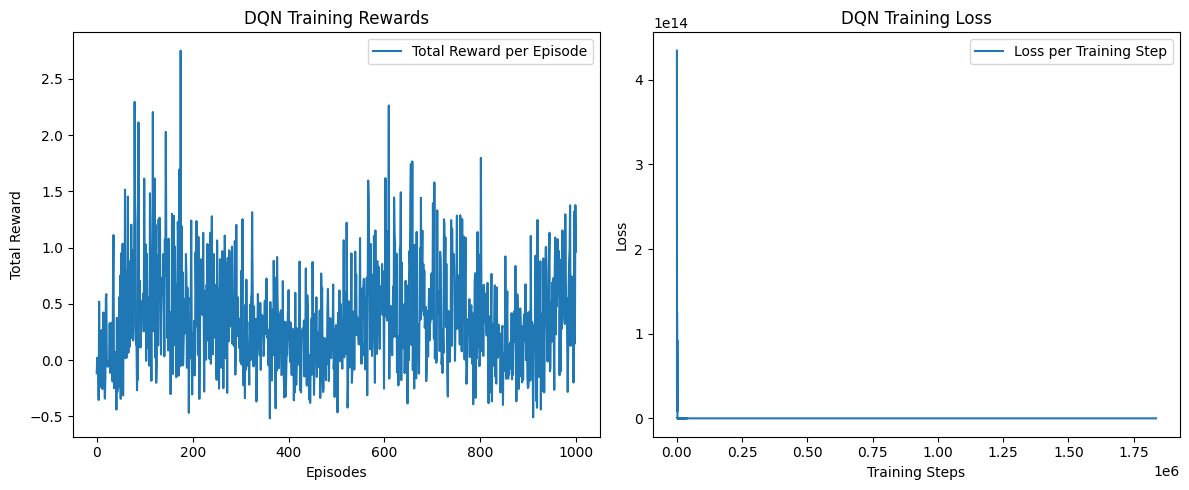


Testing DQN agent for AAPL


C:\Users\ggwzz\AppData\Local\Temp\ipykernel_24524\481734326.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])


Test completed. Total Reward: 0.0


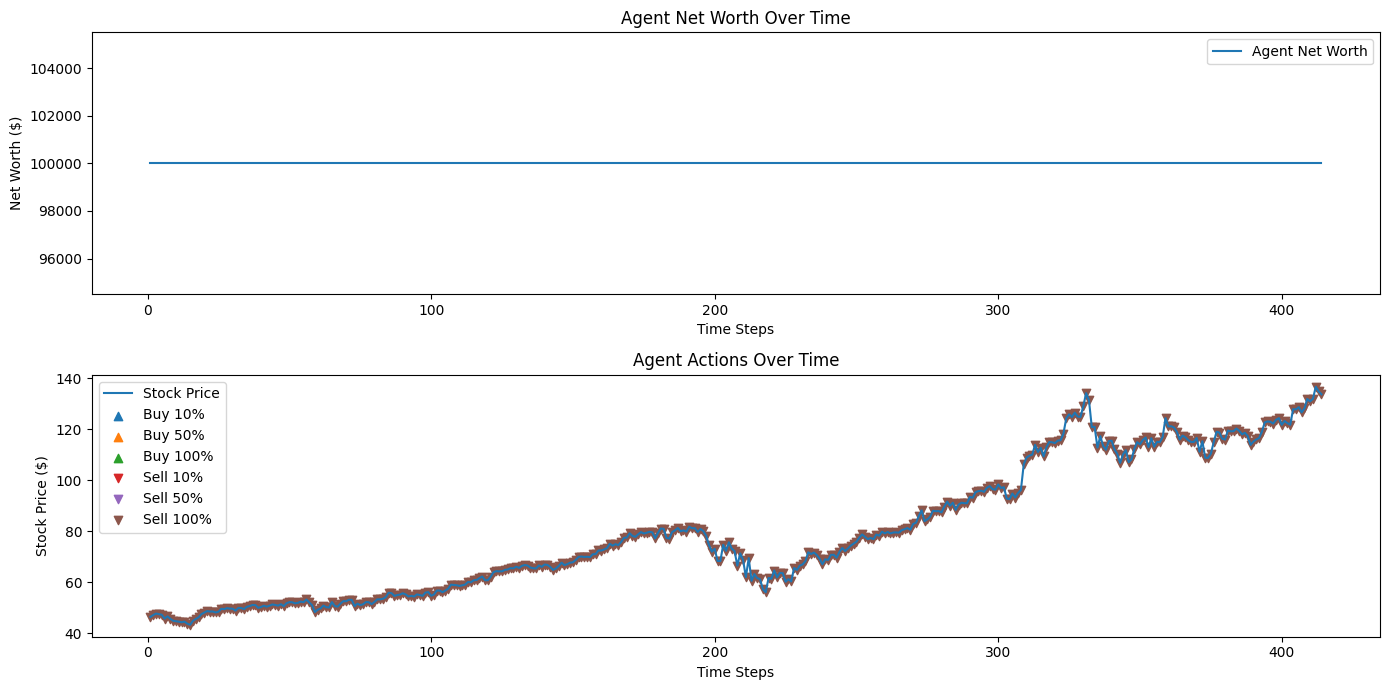

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: 0.00
Maximum Drawdown: 0.00%


C:\Users\ggwzz\AppData\Local\Temp\ipykernel_24524\2589677968.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(env.df.iloc[env.window_size - 1]['Close'])


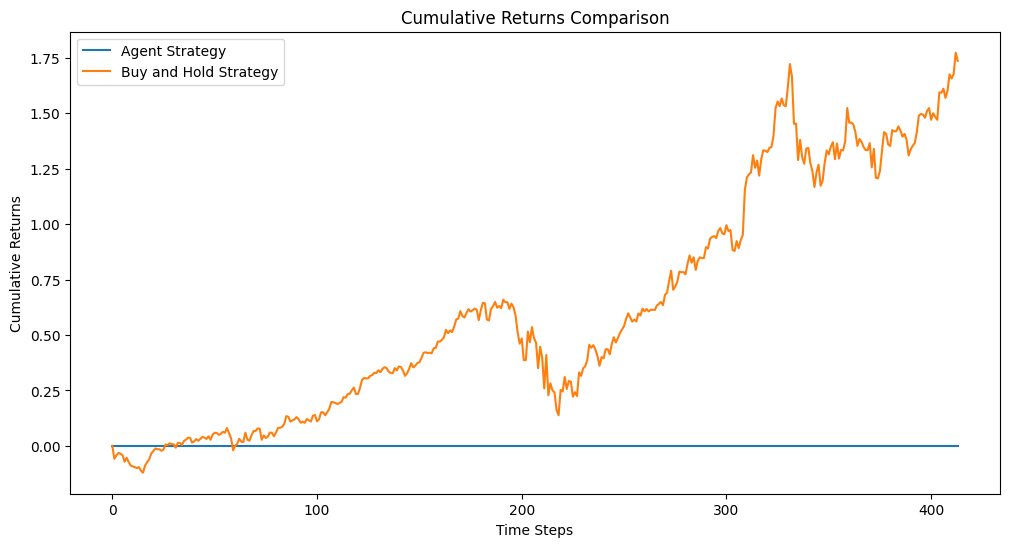

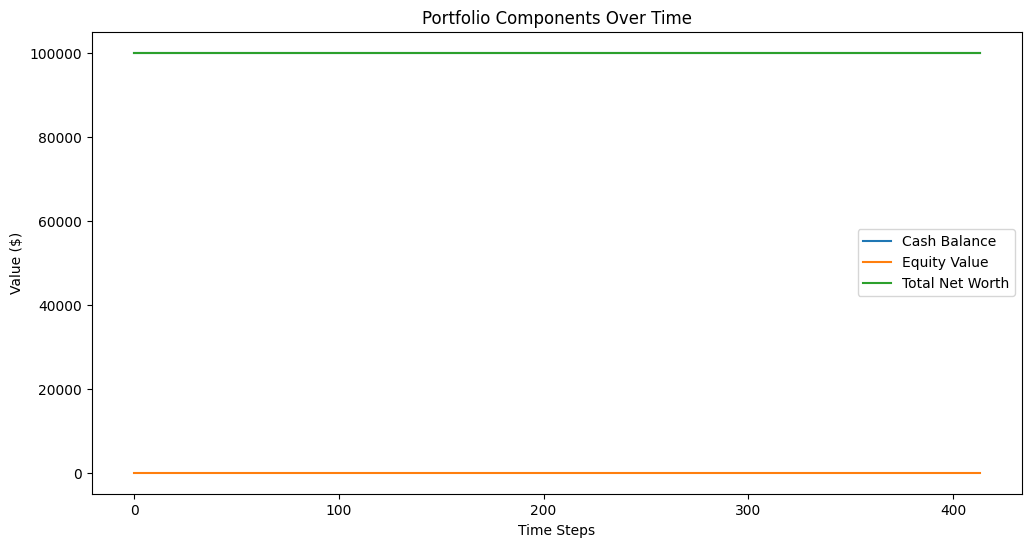


Training DQN agent for TSLA
Episode 1/1000, Total Reward: 1.2868327633183032, Epsilon: 0.01
Episode 2/1000, Total Reward: -0.008025454485902587, Epsilon: 0.01
Episode 3/1000, Total Reward: 0.08851925731393816, Epsilon: 0.01
Episode 4/1000, Total Reward: 0.13803199426546098, Epsilon: 0.01
Episode 5/1000, Total Reward: 0.08000557405922526, Epsilon: 0.01
Episode 6/1000, Total Reward: -0.08167772419093132, Epsilon: 0.01
Episode 7/1000, Total Reward: 0.046745018663282394, Epsilon: 0.01
Episode 8/1000, Total Reward: 0.08599606298067092, Epsilon: 0.01
Episode 9/1000, Total Reward: 0.07820358114560581, Epsilon: 0.01
Episode 10/1000, Total Reward: 0.021228152436368476, Epsilon: 0.01
Episode 11/1000, Total Reward: 0.04485696254055623, Epsilon: 0.01
Episode 12/1000, Total Reward: -0.20209972983831898, Epsilon: 0.01
Episode 13/1000, Total Reward: -0.02589896911509269, Epsilon: 0.01
Episode 14/1000, Total Reward: 0.29907477597286986, Epsilon: 0.01
Episode 15/1000, Total Reward: 0.1701923740717649,

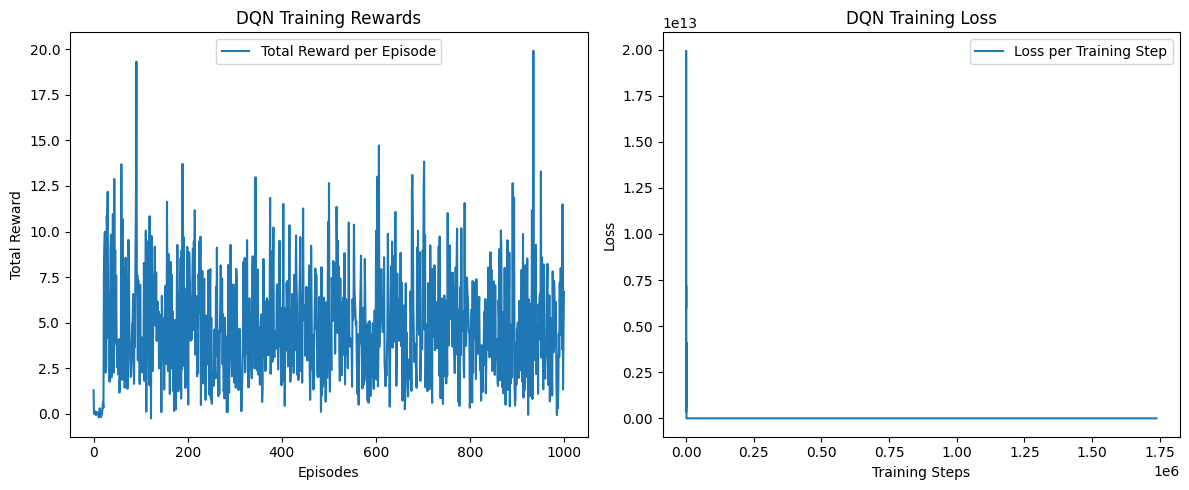


Testing DQN agent for TSLA
Test completed. Total Reward: 14.492196773509386


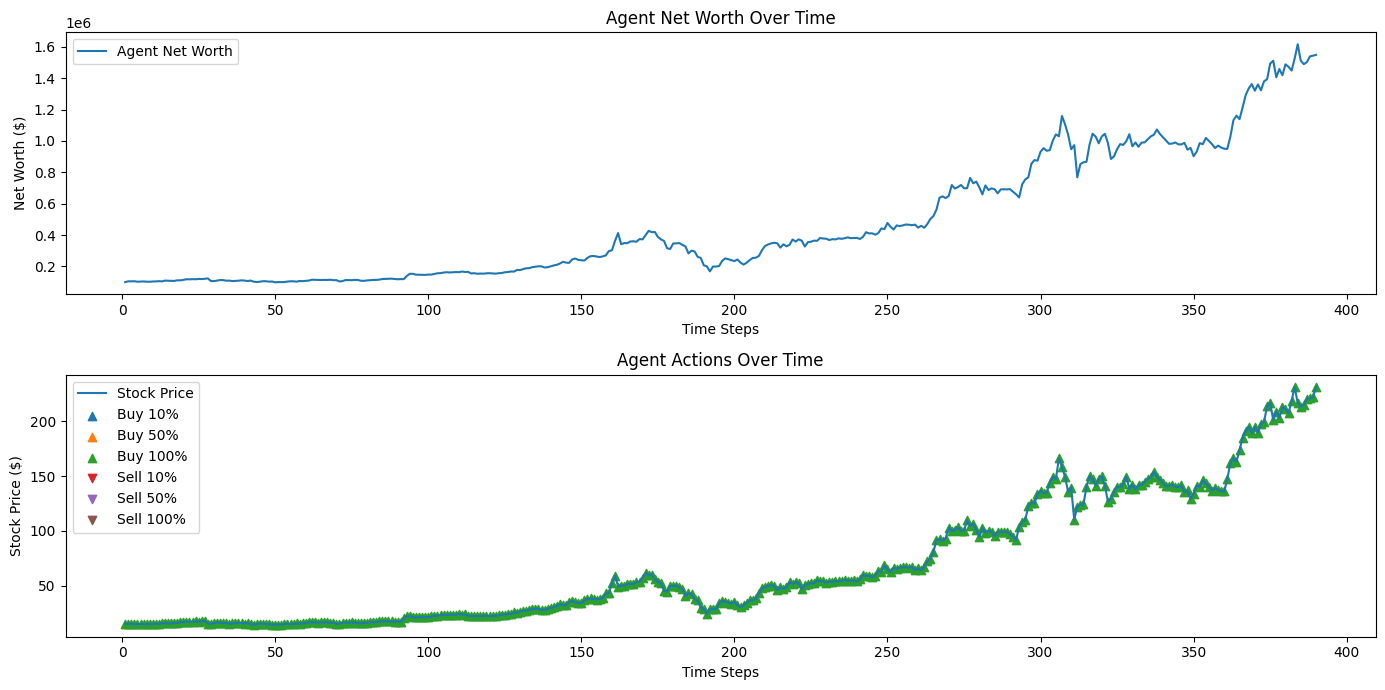

Total Return: 1449.32%
Annualized Return: 936.48%
Sharpe Ratio: 2.69
Maximum Drawdown: 60.63%


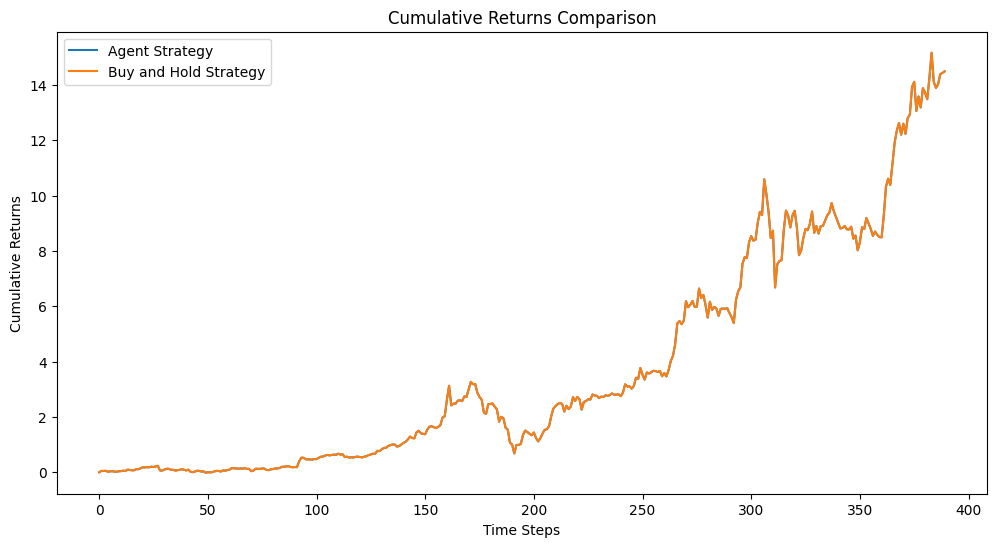

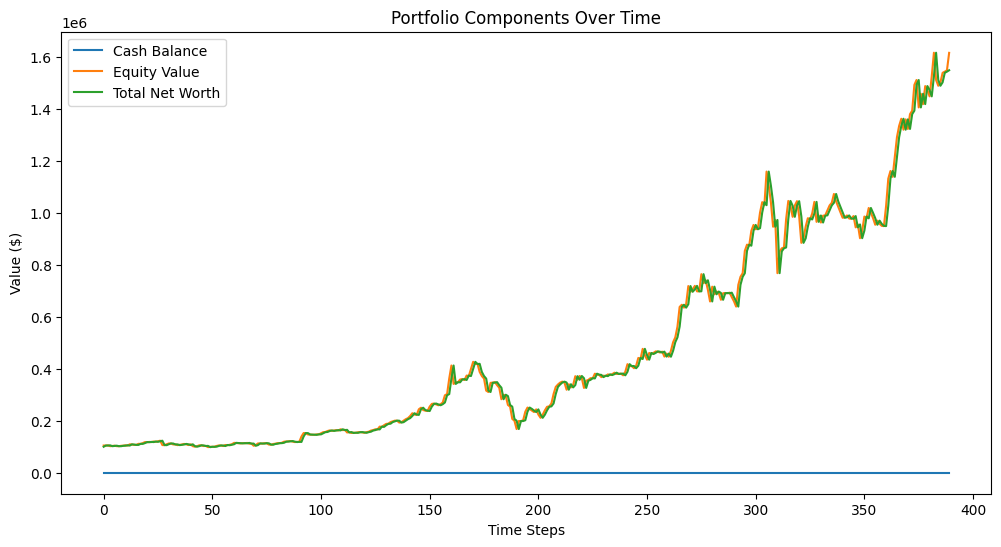


Training DQN agent for AMZN
Episode 1/1000, Total Reward: 1.5986470274551972, Epsilon: 0.01
Episode 2/1000, Total Reward: 0.4251227950349528, Epsilon: 0.01
Episode 3/1000, Total Reward: 1.6962205997817499, Epsilon: 0.01
Episode 4/1000, Total Reward: 1.7298340795652498, Epsilon: 0.01
Episode 5/1000, Total Reward: 0.5639219055591576, Epsilon: 0.01
Episode 6/1000, Total Reward: 1.4458477785692518, Epsilon: 0.01
Episode 7/1000, Total Reward: 1.4859531325300603, Epsilon: 0.01
Episode 8/1000, Total Reward: 0.6844641349724002, Epsilon: 0.01
Episode 9/1000, Total Reward: 1.5738330615033245, Epsilon: 0.01
Episode 10/1000, Total Reward: 2.101406746281237, Epsilon: 0.01
Episode 11/1000, Total Reward: 1.5183906314493458, Epsilon: 0.01
Episode 12/1000, Total Reward: 0.1717511846440409, Epsilon: 0.01
Episode 13/1000, Total Reward: 2.503022525668752, Epsilon: 0.01
Episode 14/1000, Total Reward: 1.7480991308624287, Epsilon: 0.01
Episode 15/1000, Total Reward: 1.135118355989646, Epsilon: 0.01
Episode 

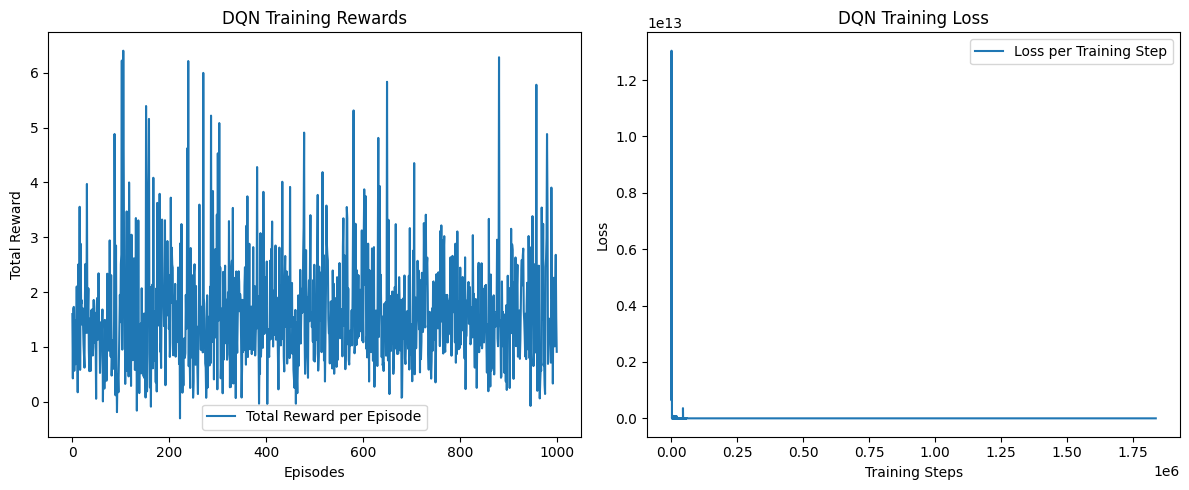


Testing DQN agent for AMZN
Test completed. Total Reward: 0.0


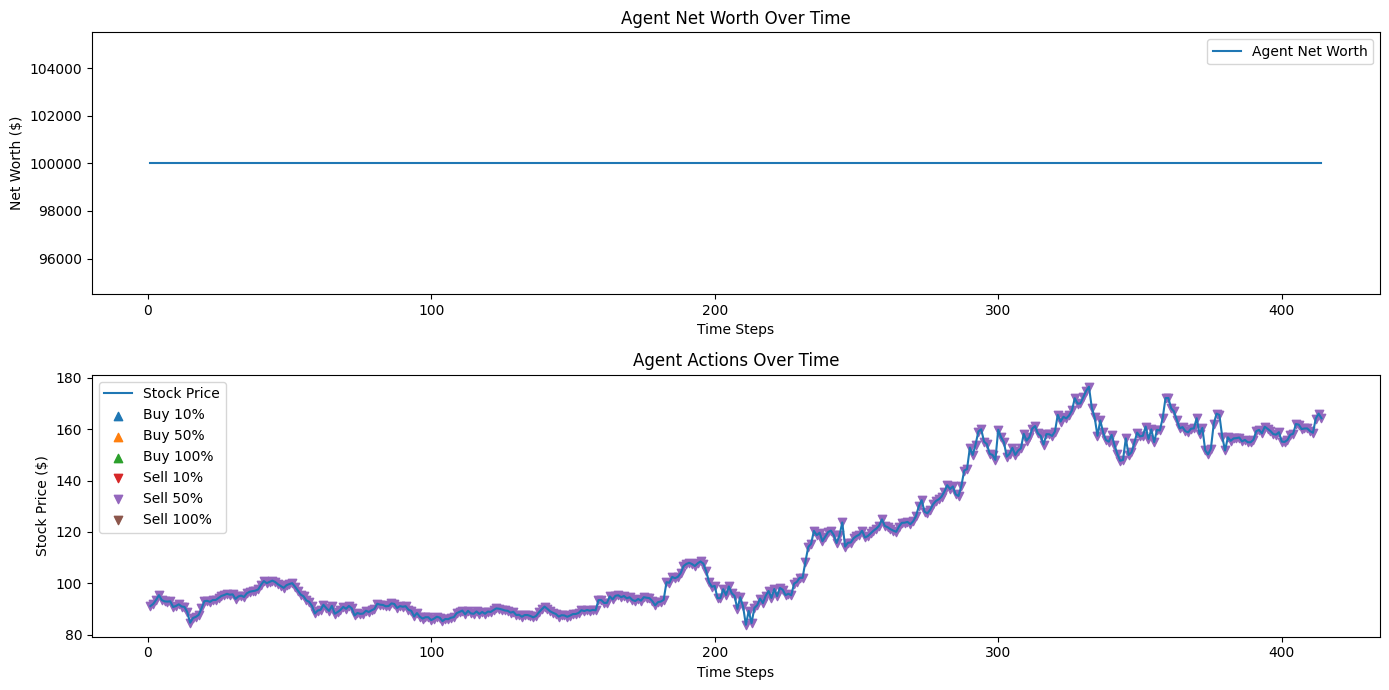

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: 0.00
Maximum Drawdown: 0.00%


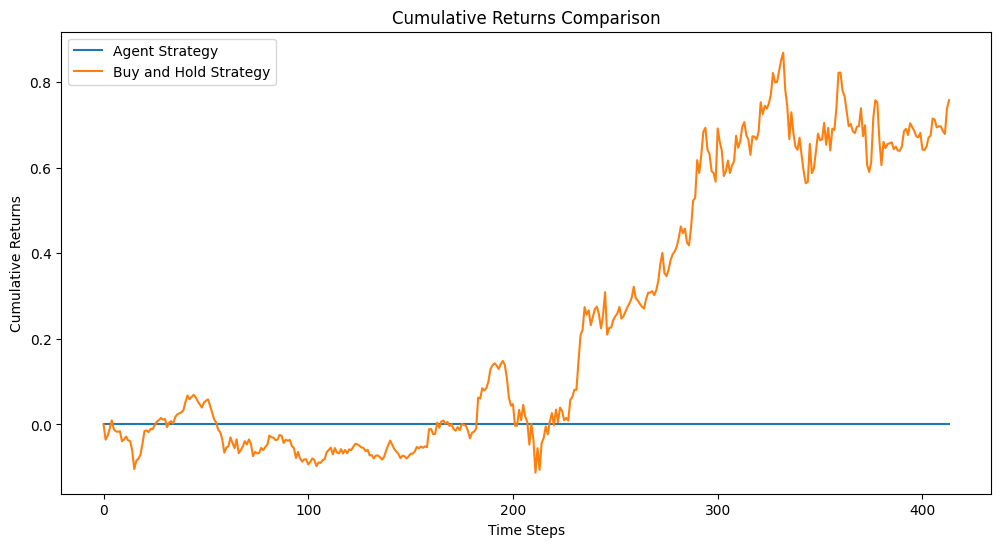

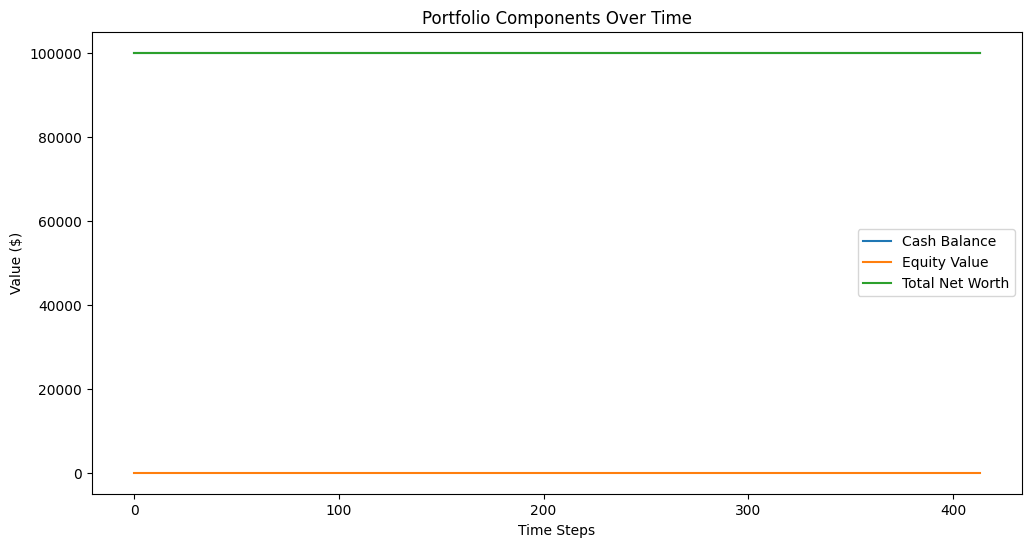


Training DQN agent for GOOGL
Episode 1/1000, Total Reward: -0.04142496694247252, Epsilon: 0.01
Episode 2/1000, Total Reward: 0.09898800101604459, Epsilon: 0.01
Episode 3/1000, Total Reward: 0.1738829877800182, Epsilon: 0.01
Episode 4/1000, Total Reward: 0.14822861932545667, Epsilon: 0.01
Episode 5/1000, Total Reward: 0.8953039012865831, Epsilon: 0.01
Episode 6/1000, Total Reward: -0.18605162625486354, Epsilon: 0.01
Episode 7/1000, Total Reward: 0.1257372838602161, Epsilon: 0.01
Episode 8/1000, Total Reward: -0.236408124692869, Epsilon: 0.01
Episode 9/1000, Total Reward: 0.2559419552942276, Epsilon: 0.01
Episode 10/1000, Total Reward: 0.007498809261131329, Epsilon: 0.01
Episode 11/1000, Total Reward: -0.1566909915130232, Epsilon: 0.01
Episode 12/1000, Total Reward: 0.3617797235416985, Epsilon: 0.01
Episode 13/1000, Total Reward: 0.32625159207800786, Epsilon: 0.01
Episode 14/1000, Total Reward: 0.1938631873965264, Epsilon: 0.01
Episode 15/1000, Total Reward: 0.4283237007933906, Epsilon:

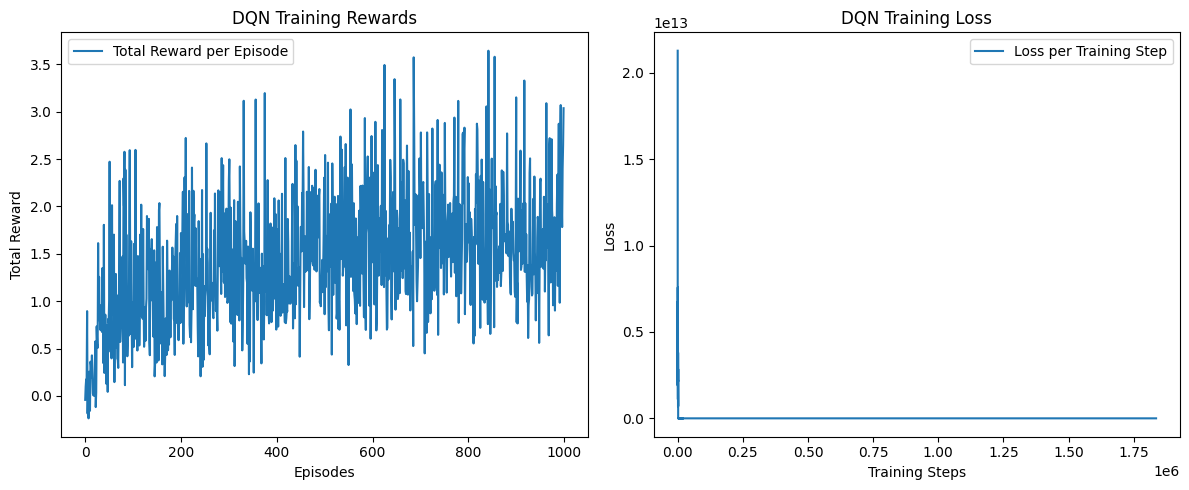


Testing DQN agent for GOOGL
Test completed. Total Reward: 0.5041432290423591


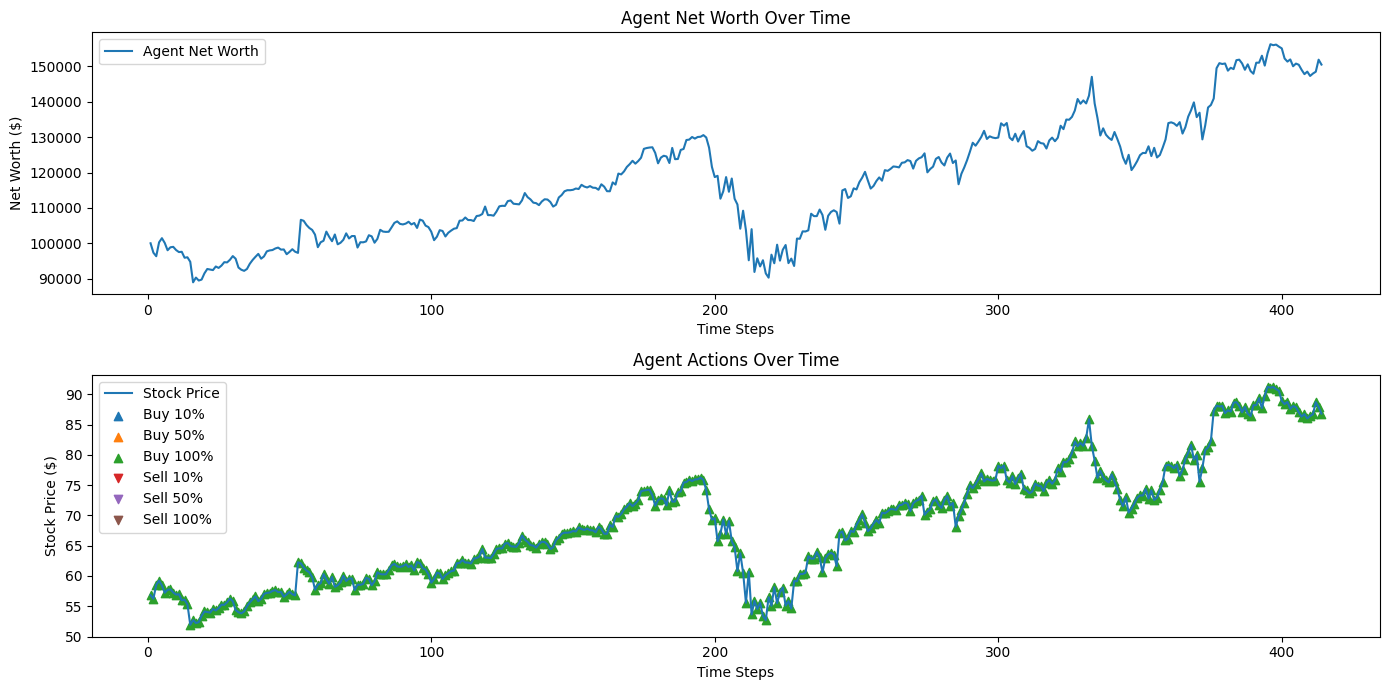

Total Return: 50.51%
Annualized Return: 30.75%
Sharpe Ratio: 0.92
Maximum Drawdown: 30.86%


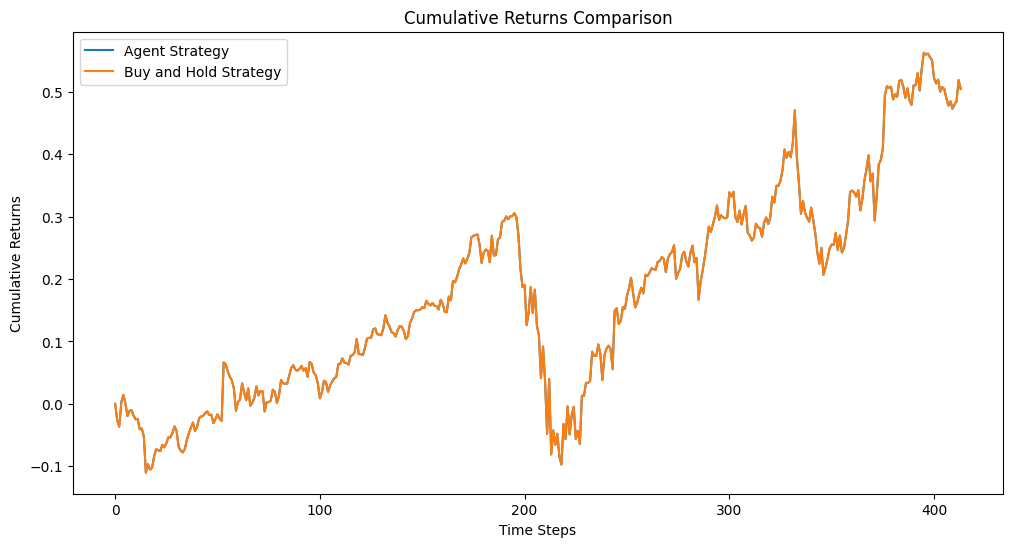

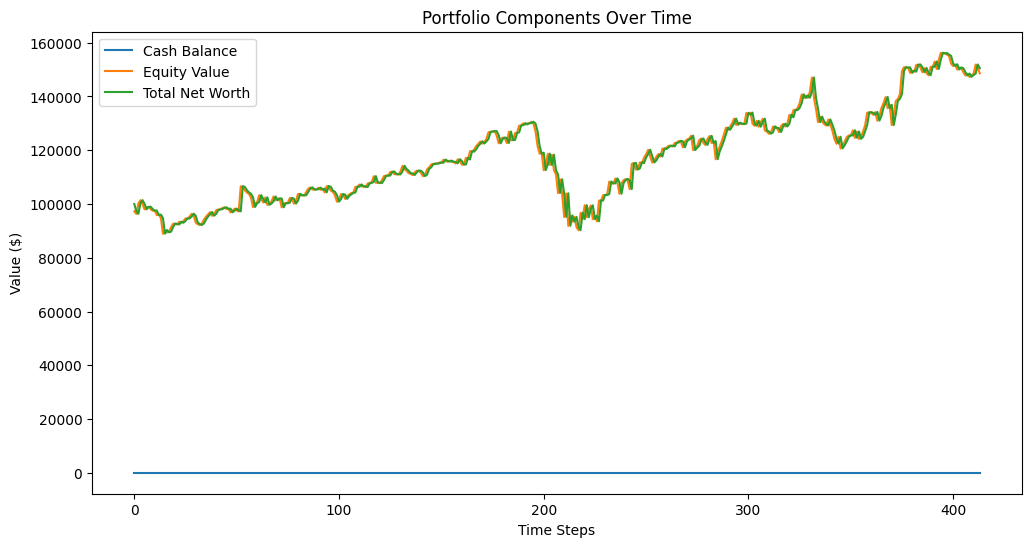


Training DQN agent for MSFT
Episode 1/1000, Total Reward: 0.1538226779899023, Epsilon: 0.01
Episode 2/1000, Total Reward: 0.01402672056619644, Epsilon: 0.01
Episode 3/1000, Total Reward: -0.04713125964933395, Epsilon: 0.01
Episode 4/1000, Total Reward: -0.0177905472052002, Epsilon: 0.01
Episode 5/1000, Total Reward: -0.008708720636615753, Epsilon: 0.01
Episode 6/1000, Total Reward: -0.01011778243408203, Epsilon: 0.01
Episode 7/1000, Total Reward: -0.023181568727169047, Epsilon: 0.01
Episode 8/1000, Total Reward: -0.039127080383911134, Epsilon: 0.01
Episode 9/1000, Total Reward: -0.020847745463619234, Epsilon: 0.01
Episode 10/1000, Total Reward: 0.013429048327369688, Epsilon: 0.01
Episode 11/1000, Total Reward: 0.028212932867488855, Epsilon: 0.01
Episode 12/1000, Total Reward: -0.022346215982360845, Epsilon: 0.01
Episode 13/1000, Total Reward: -0.040420434894695274, Epsilon: 0.01
Episode 14/1000, Total Reward: -0.06862331494016646, Epsilon: 0.01
Episode 15/1000, Total Reward: -0.074296

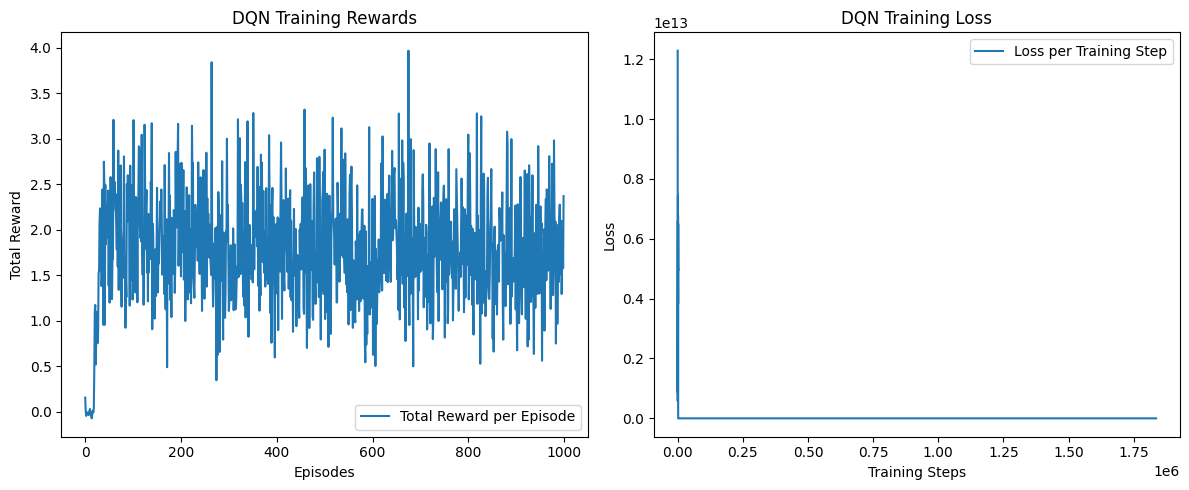


Testing DQN agent for MSFT
Test completed. Total Reward: 0.7615779318360901


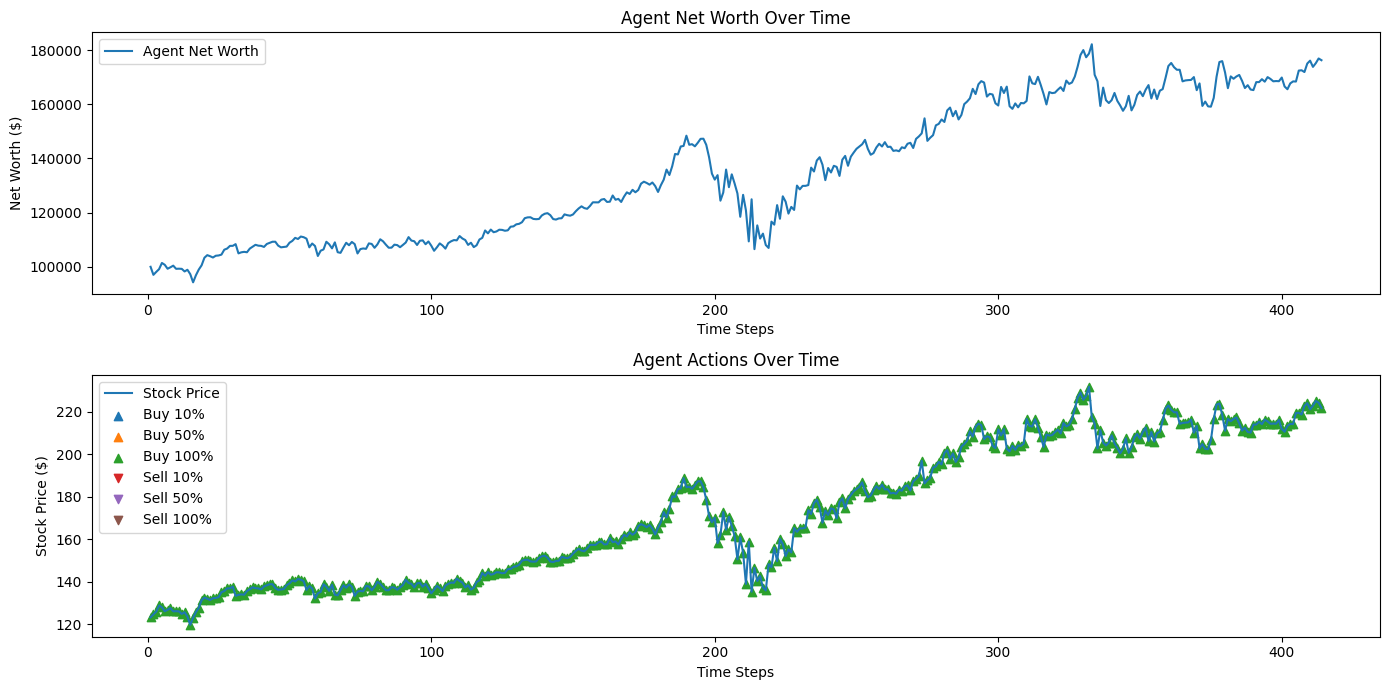

Total Return: 76.26%
Annualized Return: 46.42%
Sharpe Ratio: 1.14
Maximum Drawdown: 28.22%


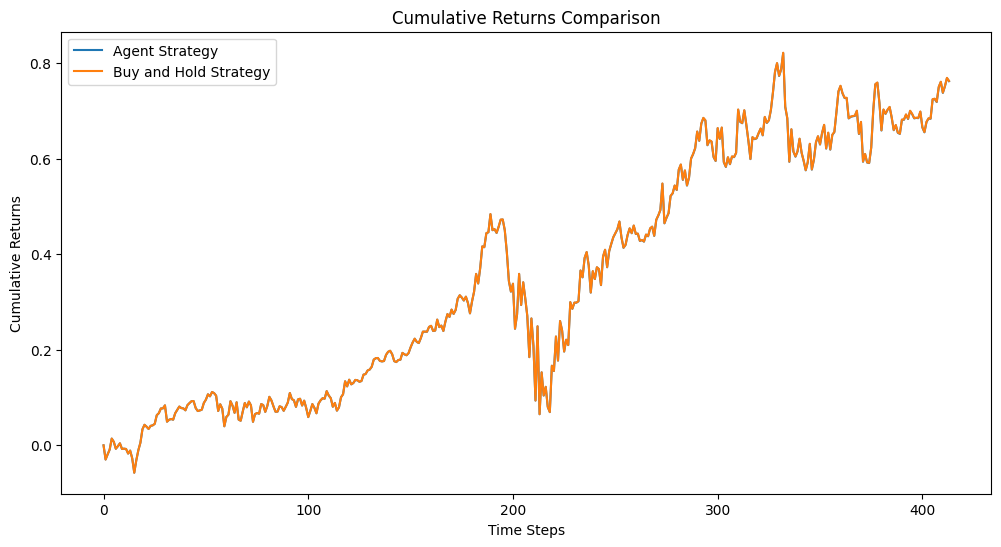

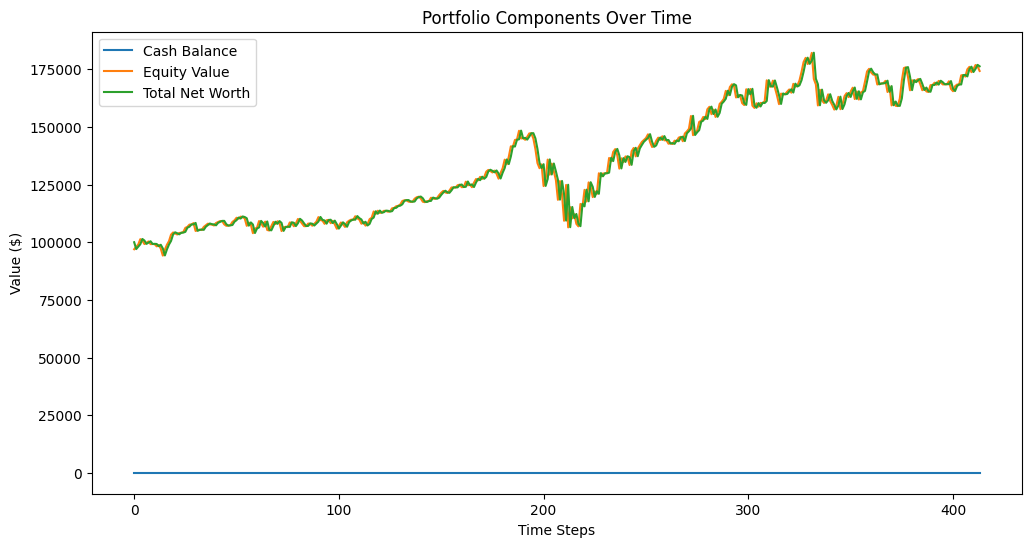


Training DQN agent for META
Episode 1/1000, Total Reward: 0.37634422724605593, Epsilon: 0.01
Episode 2/1000, Total Reward: -0.036637114657135005, Epsilon: 0.01
Episode 3/1000, Total Reward: -0.044552403081359826, Epsilon: 0.01
Episode 4/1000, Total Reward: 0.2673143628674698, Epsilon: 0.01
Episode 5/1000, Total Reward: 0.9245383413535706, Epsilon: 0.01
Episode 6/1000, Total Reward: 0.948268728581543, Epsilon: 0.01
Episode 7/1000, Total Reward: 1.0800817295453633, Epsilon: 0.01
Episode 8/1000, Total Reward: 0.7140541086009222, Epsilon: 0.01
Episode 9/1000, Total Reward: 0.46277674859604023, Epsilon: 0.01
Episode 10/1000, Total Reward: 0.21860724555480893, Epsilon: 0.01
Episode 11/1000, Total Reward: 0.4860972045721441, Epsilon: 0.01
Episode 12/1000, Total Reward: 0.47161670550468515, Epsilon: 0.01
Episode 13/1000, Total Reward: 0.14318257503372184, Epsilon: 0.01
Episode 14/1000, Total Reward: 0.1405944775695037, Epsilon: 0.01
Episode 15/1000, Total Reward: 0.8972476209496691, Epsilon: 

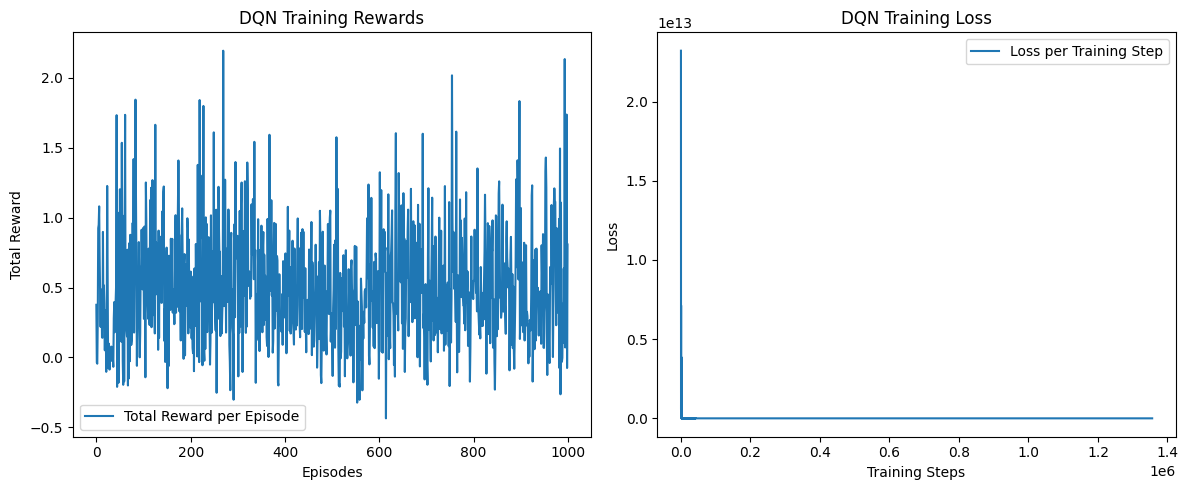


Testing DQN agent for META
Test completed. Total Reward: 0.0


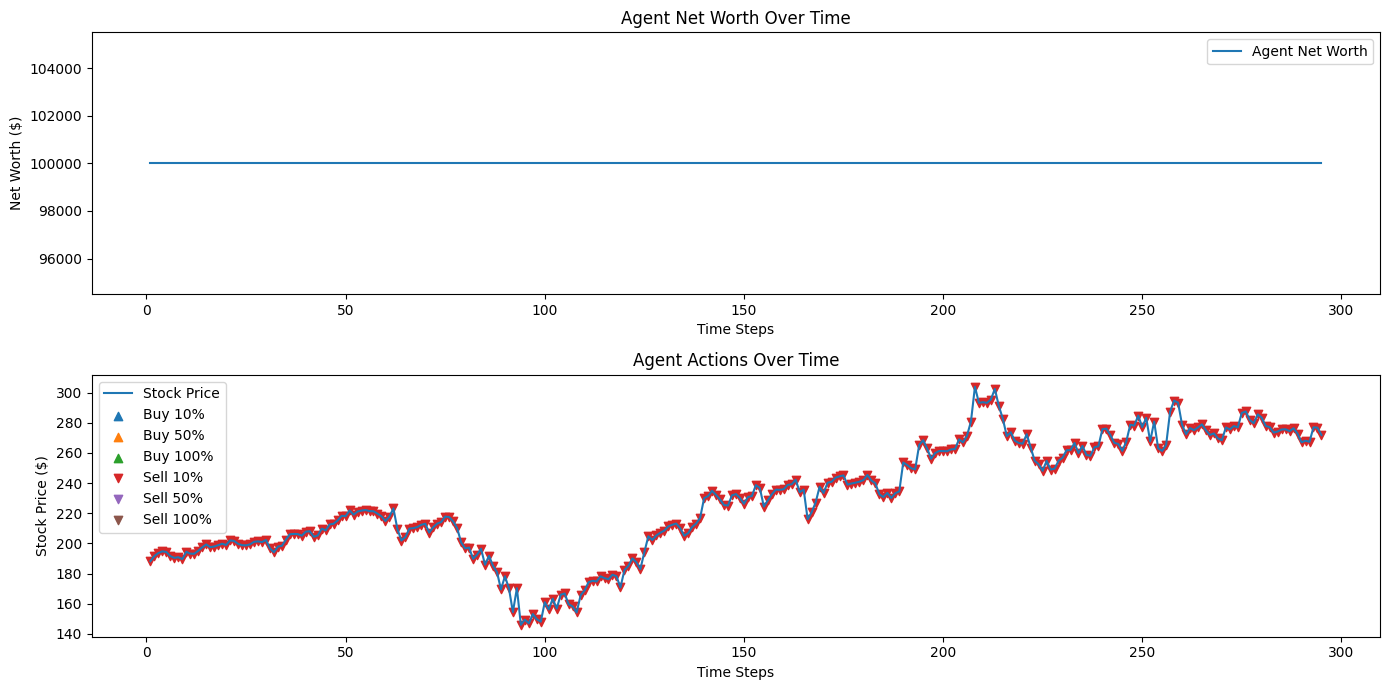

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: 0.00
Maximum Drawdown: 0.00%


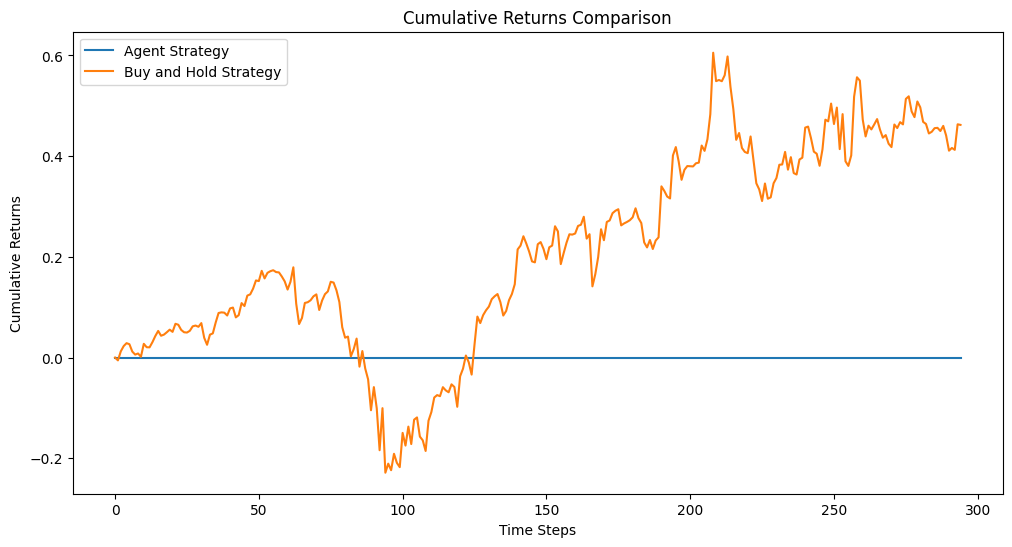

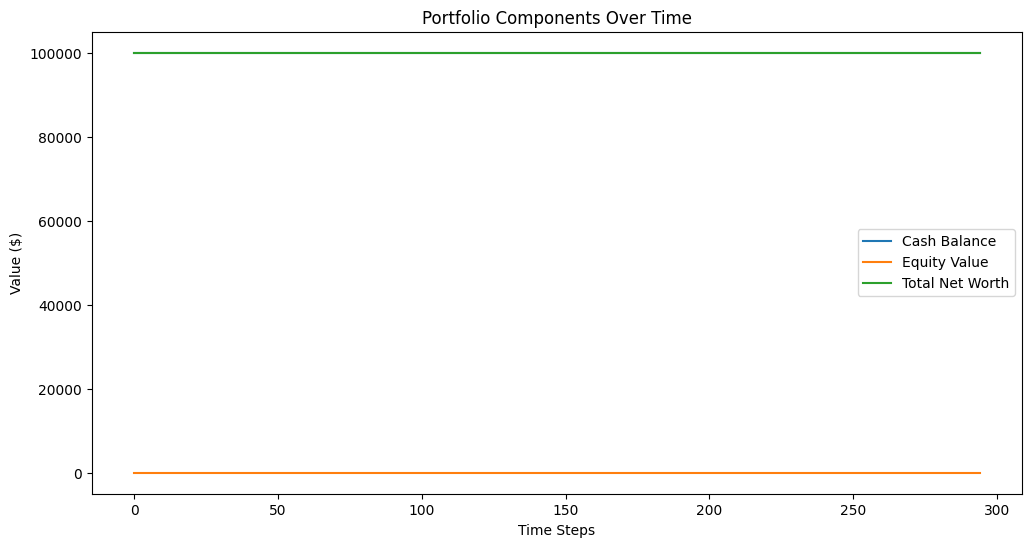


Training DQN agent for NVDA
Episode 1/1000, Total Reward: 1.319915228978211, Epsilon: 0.01
Episode 2/1000, Total Reward: 4.115802896303714, Epsilon: 0.01
Episode 3/1000, Total Reward: 2.646756945974958, Epsilon: 0.01
Episode 4/1000, Total Reward: 1.8148930000882317, Epsilon: 0.01
Episode 5/1000, Total Reward: 3.206087051324738, Epsilon: 0.01
Episode 6/1000, Total Reward: 0.4052822542301739, Epsilon: 0.01
Episode 7/1000, Total Reward: 1.0577316383328492, Epsilon: 0.01
Episode 8/1000, Total Reward: 0.7459016025842737, Epsilon: 0.01
Episode 9/1000, Total Reward: 1.559640471775096, Epsilon: 0.01
Episode 10/1000, Total Reward: 0.8059782568917602, Epsilon: 0.01
Episode 11/1000, Total Reward: 1.4793907354117888, Epsilon: 0.01
Episode 12/1000, Total Reward: 0.006287052710546528, Epsilon: 0.01
Episode 13/1000, Total Reward: 0.033664928672852805, Epsilon: 0.01
Episode 14/1000, Total Reward: 0.08843085520994573, Epsilon: 0.01
Episode 15/1000, Total Reward: 0.013865360512337109, Epsilon: 0.01
Epi

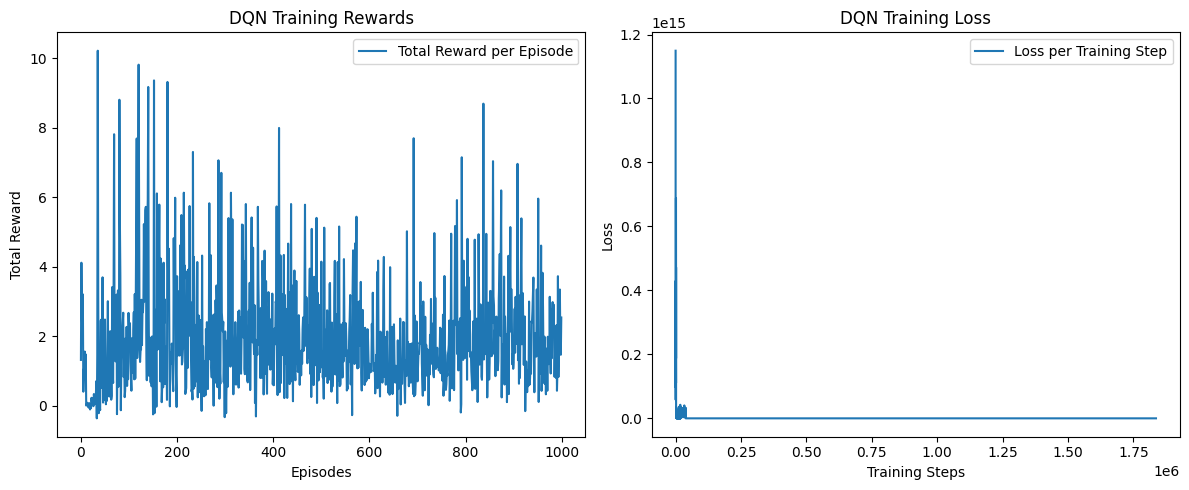


Testing DQN agent for NVDA
Test completed. Total Reward: 0.0


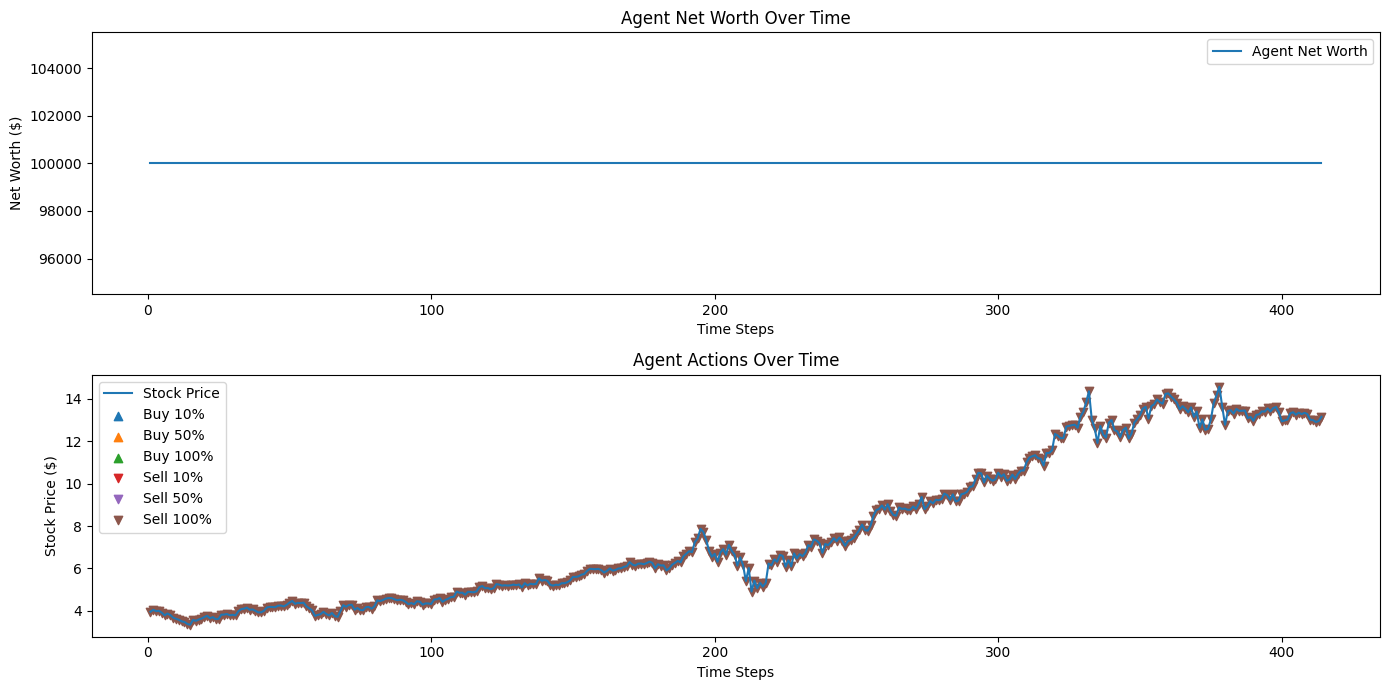

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: 0.00
Maximum Drawdown: 0.00%


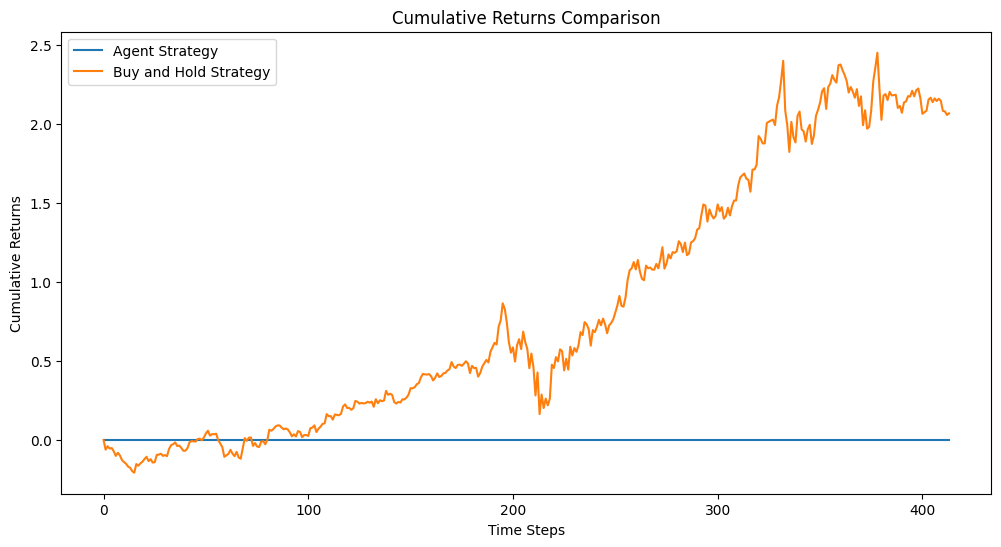

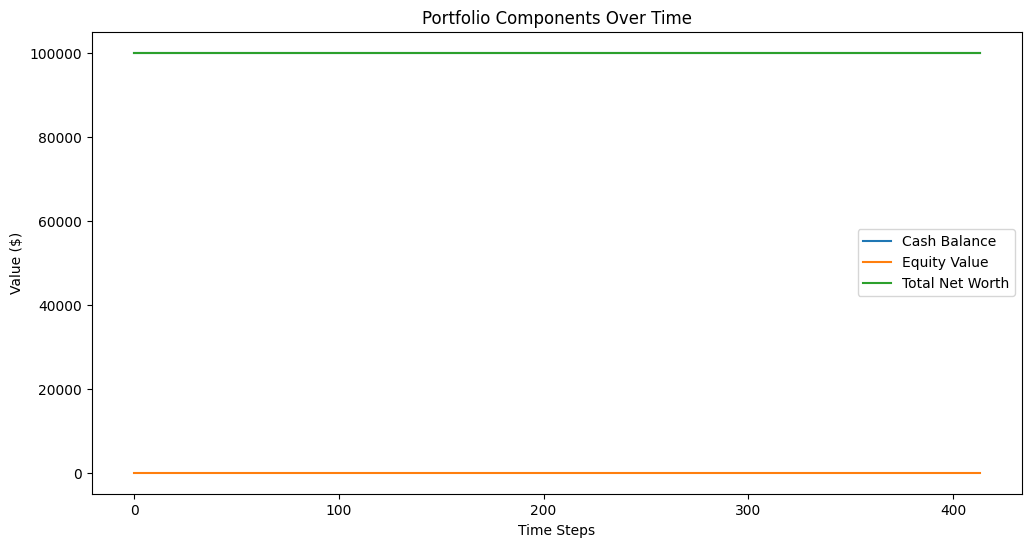

In [12]:
if __name__ == "__main__":
    num_episodes = 1000  # Adjust as needed
    batch_size = 64
    target_update_freq = 10

    for ticker in STOCKS:
        print(f"\nTraining DQN agent for {ticker}")
        # Prepare environment
        df_train = train_data[ticker]
        env = TradingEnv(df_train)

        # Determine state and action sizes
        state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
        action_size = env.action_space.n

        # Initialize agent
        agent = DQNAgent(state_size=state_size, action_size=action_size, device='cpu')

        # Train agent
        rewards_history, losses = train_dqn_agent(env, agent, num_episodes=num_episodes, batch_size=batch_size, target_update_freq=target_update_freq)

        # Save the trained model
        torch.save(agent.q_network.state_dict(), f'dqn_trading_agent_{ticker}.pt')
        print(f"Trained DQN agent for {ticker} saved as dqn_trading_agent_{ticker}.pt")

        # Plot training metrics
        plot_training_metrics(rewards_history, losses)

         # Testing the agent on test data
        print(f"\nTesting DQN agent for {ticker}")
        df_test = test_data[ticker]
        env_test = TradingEnv(df_test)
        agent.q_network.eval()
        net_worths, actions, prices, steps, balances, shares_helds = test_dqn_agent(env_test, agent)

        # Compute equity values
        equity_values = [shares_helds[i] * prices[i] for i in range(len(shares_helds))]

        # Plot test performance
        plot_test_performance(net_worths, actions, prices, steps)
        compute_performance_metrics(net_worths)
        plot_cumulative_returns(net_worths, env_test)
        plot_portfolio_components(net_worths, balances, equity_values)


In [13]:
if __name__ == "__main__":
    # Load the test data
    ticker = 'AAPL'
    df_test = test_data[ticker]
    env_test = TradingEnv(df_test)
    
    # Initialize agent
    state_size = env_test.observation_space.shape[0] * env_test.observation_space.shape[1]
    action_size = env_test.action_space.n
    
    agent = DQNAgent(state_size=state_size, action_size=action_size, device='cpu')
    # Load the trained model
    agent.q_network.load_state_dict(torch.load(f'dqn_trading_agent_{ticker}.pt'))
    agent.q_network.eval()
    
    # Test the agent
    net_worths, actions, prices, steps = test_dqn_agent(env_test, agent)
    
    # Plot the performance
    plot_test_performance(net_worths, actions, prices, steps)
    
    # Compute performance metrics
    compute_performance_metrics(net_worths)
    
    # Compute buy-and-hold net worth
    buy_and_hold_net_worth = compute_buy_and_hold(env_test)
    print(f"Buy and Hold Net Worth: ${buy_and_hold_net_worth:.2f}")
    print(f"Agent's Final Net Worth: ${net_worths[-1]:.2f}")

C:\Users\ggwzz\AppData\Local\Temp\ipykernel_24524\1920736134.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.q_network.load_state_dict(torch.load(f'dqn_trading_ag

Test completed. Total Reward: 0.0


ValueError: too many values to unpack (expected 4)